In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location("src", "/home/anuiel/Remote/Anuiel/sound-dz-1/pytorch_project_template/src/__init__.py")
src = importlib.util.module_from_spec(spec)

sys.modules["src"] = src
spec.loader.exec_module(src)

## CTCEncoder testing

**TODO**

- BPE
- Beam Search
- LM perplexity score (probably [meta-llama/Llama-3.2-1B](https://huggingface.co/meta-llama/Llama-3.2-1B))

In [3]:
from src.datasets import LibrispeechDataset
from src.text_encoder import CTCTextEncoder

In [4]:
text_encoder = CTCTextEncoder()
instance_transforms = {
    "get_spectrogram": lambda x: x
}
dataset = LibrispeechDataset(part="train-clean-100", text_encoder=text_encoder, instance_transforms=instance_transforms)

In [56]:
import IPython

x = dataset[-20]

IPython.display.Audio(x['audio_path'])

In [72]:
x['text_encoded'].shape, x["audio"].shape, x['spectrogram'].shape

(torch.Size([1, 247]), torch.Size([1, 274640]), torch.Size([1, 274640]))

In [57]:
from torchaudio.pipelines import WAV2VEC2_ASR_BASE_100H

bundle = WAV2VEC2_ASR_BASE_100H

model = bundle.get_model()

In [58]:
import torchaudio

waveform = torchaudio.functional.resample(x['audio'], dataset.target_sr, bundle.sample_rate)
labels = bundle.get_labels()

In [59]:
text_to_target = {
    letter.lower(): idx
    for idx, letter in enumerate(labels)
}

text_to_target[" "] = text_to_target["|"]

In [60]:
import torch

emissions, _ = model(waveform)
target = torch.tensor([text_to_target[letter] for letter in x['text']]).unsqueeze(0)

In [61]:
emissions.shape

torch.Size([1, 858, 29])

In [62]:
from torch.nn import CTCLoss

loss = CTCLoss(blank=0)
loss.forward(
    emissions.transpose(0, 1),
    target,
    torch.full(size=(1,), fill_value=emissions.shape[1], dtype=torch.long),
    torch.full(size=(1,), fill_value=target.shape[1], dtype=torch.long),
)

tensor(-48.0997, grad_fn=<MeanBackward0>)

In [63]:
emission = emissions.squeeze(0)

In [64]:
from src.text_encoder import CTCTextEncoder

custom_encoder = CTCTextEncoder()

custom_encoder.EMPTY_TOK = "-"
custom_encoder.vocab = labels

custom_encoder.ind2char = dict(enumerate(custom_encoder.vocab))
custom_encoder.char2ind = {v: k for k, v in custom_encoder.ind2char.items()}
custom_encoder.EMPTY_IND = custom_encoder.char2ind[custom_encoder.EMPTY_TOK]

In [65]:
custom_encoder.decode(emission, 'argmax')

"DIDN'T|KNOW|HE|LIVED|UP|HERE|HE|HAD|SEEN|THE|GAMEWARDEN|FROM|WHOM|SHE|HAD|PROCURED|HER|LICENCE|AND|SO|HUNTED|UP|OUR|CAMP|HE|IS|AN|ODD|LOOKING|INDIVIDUAL|WITH|SAD|EYES|AND|A|DROOPING|MOUTH|WHICH|GIVES|HIS|FACE|A|MOST|HOPELESS|REPROACHFUL|EXPRESSION|"

In [79]:
custom_encoder._ctc_decode_argmax(emission)

## Spectrogram gaming

In [3]:
from src.datasets import LibrispeechDataset
from src.text_encoder import CTCTextEncoder

text_encoder = CTCTextEncoder()
instance_transforms = {
    "get_spectrogram": lambda x: x
}
dataset = LibrispeechDataset(part="train-clean-100", text_encoder=text_encoder, instance_transforms=instance_transforms)

In [4]:
# from https://github.com/markovka17/dla/blob/2024/week03/seminar03_1.ipynb
from IPython import display
from matplotlib import pyplot as plt
import torchaudio

import torch
import torch.nn.functional as F

In [5]:
mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
    sample_rate=dataset.target_sr,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=80,
)

In [6]:
x = dataset[2222]
audio = x['audio']
sr = dataset.target_sr


mel_spectrogram = mel_spectrogramer(audio).squeeze(0)

print(x['text']), mel_spectrogram.shape

am i come to a friend she asked in a tone full of mournful dignity


(None, torch.Size([80, 340]))

In [7]:
from src.model.conformer import Conformer

conformer = Conformer(
    n_features=80,
    n_hidden=160,
    n_layers=2,
    n_heads=4,
    depthwise_conv_kernel_size=31,
    max_seq_len=340,
    dropout=0.1
)

In [8]:
spectorgramm = mel_spectrogram.unsqueeze(0)
spectorgramm_lenght = torch.tensor([340])

In [9]:
conformer(spectorgramm, spectorgramm_lenght)

{'log_probs': tensor([[[-4.0912, -5.6356, -3.9448,  ..., -4.0329, -4.3350, -4.2843],
          [-4.4711, -4.0174, -3.9279,  ..., -2.9171, -4.8172, -3.3770],
          [-5.2882, -5.3091, -4.5926,  ..., -4.0634, -4.8899, -4.0330],
          ...,
          [-2.5529, -4.6399, -2.6462,  ..., -4.9620, -4.0127, -3.7655],
          [-1.8646, -4.0093, -5.5421,  ..., -4.9126, -3.7893, -4.2840],
          [-3.2249, -5.4149, -4.4284,  ..., -5.1673, -5.4629, -3.7144]]],
        grad_fn=<LogSoftmaxBackward0>),
 'log_probs_length': tensor([340])}

In [9]:
a = plot_spectrogram(mel_spectrogram)

(2000, 500)


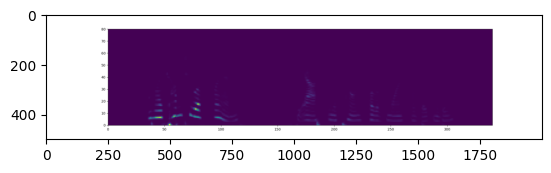

In [13]:
aa = plt.imshow(a.transpose(0, 1).transpose(1, 2).numpy())
plt.show()

In [12]:
mel_spectrogram = mel_spectrogramer(audio)
log_mel_spectrogram = torch.log(mel_spectrogram).squeeze()
plt.figure(figsize=(20, 5))
plt.imshow(log_mel_spectrogram)
plt.show()

In [116]:
log_mel_spectrogram.shape

torch.Size([80, 248])

## CER and WER

2